In [1]:
#import library
from scipy.stats import norm
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
%matplotlib inline

Define the prior by multuvatiate distribution

In [48]:
mu_1= [0.,0.]

cov_1 = [[ 1,  0.],
        [ 0.,  1]]


In [49]:
## initial the model

c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)
np.random.seed(121)
## define the log probability
def joint_log_post(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu_1,
            covariance_matrix= cov_1)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.log_prob(tf.squeeze(z))
          +tf.reduce_sum(y.log_prob(D)))

In [64]:
x_1, y_1 = np.mgrid[-2:2:.03, -2:2:.03]
pos = np.empty(x_1.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x_1; pos[:, :, 1] = y_1


post = np.empty(x_1.shape)

for i in range(np.arange(-2,2,.03).shape[0]):
    for j in range(np.arange(-2,2,.03).shape[0]):
        post[i][j] = joint_log_post(D,pos[i][j][0],pos[i][j][1])

In [65]:
joint_log_post(D,-1.,-0.1)

<tf.Tensor: id=22258302, shape=(), dtype=float32, numpy=-1839.4453>

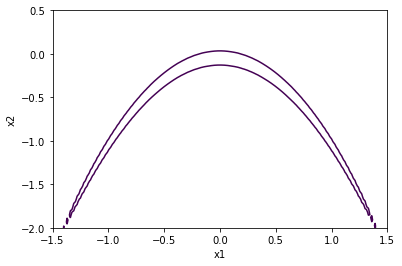

In [66]:
def draw_post():
    plt.contour(x_1, y_1, post,[joint_log_post(D,-0.,-0.13)])
    plt.xlim(-1.5,1.5)
    plt.ylim(-2,0.5)
    plt.xlabel("x1")
    plt.ylabel("x2")
draw_post()

## <b>RMH

Adjust the step size

In [7]:
num_results = 1000
burnin = 500

initial_chain_state = [
    -1.7 * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1.5 * tf.ones([], dtype=tf.float32, name="init_t2")
]

dtype = np.float32

unnormalized_posterior_log_prob = lambda *args: joint_log_post(D, *args)

# adjust the step size of Random walk Matroplis Hasting MCMC
def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

samples, kernel_results= tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.1, dtype=dtype),
        seed=42))  # For determinism.


samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 18.3%


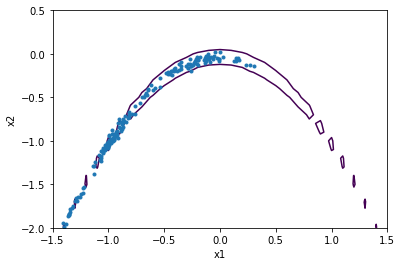

In [8]:
x_accepted = samples[np.where(accepted ==True)][:,0]
y_accepted = samples[np.where(accepted ==True)][:,1]
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))
draw_post()

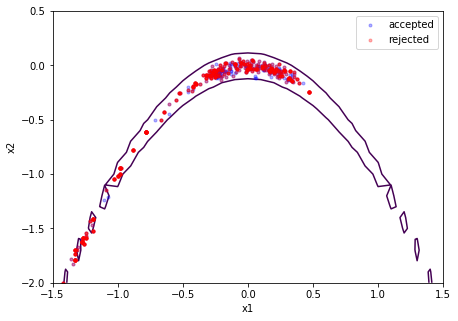

In [9]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted = samples[np.where(accepted ==True)][:,0]
y_accepted = samples[np.where(accepted ==True)][:,1]
x_rejected = samples[np.where(accepted ==False)][:,0]
y_rejected = samples[np.where(accepted ==False)][:,1]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.plot(x_accepted,y_accepted,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected,y_rejected,'r.',label = 'rejected',alpha = 0.3)
        
plt.legend(loc = 'upper right')
# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/Banana_randomwalk.png'.format(i))

<b> HMC

In [10]:
num_results = 1000
burnin = 500

initial_chain_state = [
    -1. * tf.ones([], dtype=tf.float32, name="init_t1"),
    -1. * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [11]:
samples

array([[ 0.5079671 , -0.26345187],
       [ 0.5058588 , -0.2700298 ],
       [ 0.58670473, -0.31912857],
       ...,
       [ 0.24405877, -0.05367981],
       [ 0.23213382, -0.05805278],
       [ 0.29508296, -0.08980922]], dtype=float32)

Acceptance rate: 98.7%


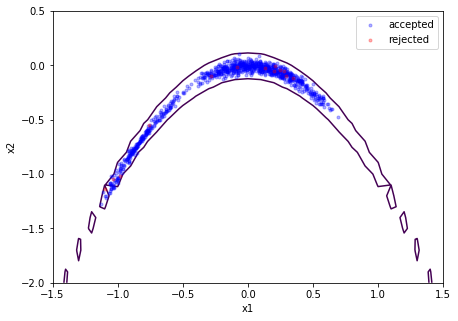

In [12]:
plt.figure(figsize=(7,5))
draw_post()
x_accepted = samples[np.where(accepted ==True)][:,0]
y_accepted = samples[np.where(accepted ==True)][:,1]
x_rejected = samples[np.where(accepted ==False)][:,0]
y_rejected = samples[np.where(accepted ==False)][:,1]

plt.xlim(-1.5,1.5)
plt.ylim(-2,0.5)
plt.plot(x_accepted,y_accepted,'b.',label = 'accepted',alpha = 0.3)
plt.plot(x_rejected,y_rejected,'r.',label = 'rejected',alpha = 0.3)
        
plt.legend(loc = 'upper right')

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


<b> Hessian MCMC - banana v1.0

Set up the target probability density

In [9]:
mean = [0.,0.]

<b> Gradient Descent

In [10]:
## Block out in case run by accident, takes too long to run 28 min
mu = tf.constant([-0.1, -0.])
for i in range(100000):
    with tf.GradientTape() as t:  
        t.watch(mu)
        theta1 = mu[0]
        theta2 = mu[1]
        loss = tf.negative(joint_log_post(D,theta1,theta2))
        dlossdmu = t.gradient(loss,mu)
        print(mu.numpy(),dlossdmu.numpy())
        mu = mu - 0.000001*dlossdmu

[-0.1 -0. ] [-8.67386  43.369297]
[-9.999133e-02 -4.336930e-05] [-8.664088 43.324196]
[-9.9982664e-02 -8.6693493e-05] [-8.654328 43.279144]
[-0.09997401 -0.00012997] [-8.644575 43.234116]
[-0.09996536 -0.00017321] [-8.634841 43.189163]
[-0.09995673 -0.0002164 ] [-8.625114 43.14424 ]
[-0.0999481  -0.00025954] [-8.615404 43.09939 ]
[-0.09993949 -0.00030264] [-8.605703 43.05457 ]
[-0.09993088 -0.00034569] [-8.596013 43.009792]
[-0.09992228 -0.0003887 ] [-8.586334 42.96506 ]
[-0.0999137  -0.00043167] [-8.576669 42.920383]
[-0.09990513 -0.00047459] [-8.567016 42.875755]
[-0.09989656 -0.00051747] [-8.557373 42.83117 ]
[-0.099888  -0.0005603] [-8.547737 42.786606]
[-0.09987945 -0.00060308] [-8.538121 42.74213 ]
[-0.09987091 -0.00064582] [-8.528508 42.69766 ]
[-0.09986238 -0.00068852] [-8.518915 42.653275]
[-0.09985387 -0.00073118] [-8.509334 42.608932]
[-0.09984536 -0.00077378] [-8.499761 42.564625]
[-0.09983686 -0.00081635] [-8.490195 42.520344]
[-0.09982836 -0.00085887] [-8.480644 42.476128

[-0.09859967 -0.00705089] [-7.1071234 36.0403   ]
[-0.09859256 -0.00708693] [-7.0992303 36.00287  ]
[-0.09858546 -0.00712293] [-7.091341 35.96545 ]
[-0.09857837 -0.0071589 ] [-7.0834656 35.928093 ]
[-0.09857129 -0.00719483] [-7.0756016 35.890785 ]
[-0.09856421 -0.00723072] [-7.06774 35.85348]
[-0.09855714 -0.00726657] [-7.0598903 35.81623  ]
[-0.09855007 -0.00730239] [-7.052052 35.77903 ]
[-0.09854302 -0.00733817] [-7.044219 35.741848]
[-0.09853598 -0.00737391] [-7.0364003 35.704727 ]
[-0.09852894 -0.00740961] [-7.028592 35.667652]
[-0.09852192 -0.00744528] [-7.0207887 35.630592 ]
[-0.0985149  -0.00748091] [-7.0129957 35.59358  ]
[-0.09850789 -0.0075165 ] [-7.005207 35.55658 ]
[-0.09850089 -0.00755206] [-6.9974375 35.51967  ]
[-0.09849389 -0.00758758] [-6.9896727 35.482773 ]
[-0.0984869  -0.00762306] [-6.9819174 35.44592  ]
[-0.09847992 -0.00765851] [-6.974166 35.409077]
[-0.09847295 -0.00769392] [-6.9664273 35.37229  ]
[-0.09846598 -0.00772929] [-6.9586997 35.335552 ]
[-0.09845902 -0.

[-0.09750955 -0.0126095 ] [-5.902821 30.267914]
[-0.09750365 -0.01263977] [-5.8963356 30.236486 ]
[-0.09749775 -0.01267   ] [-5.8898616 30.205114 ]
[-0.09749186 -0.01270021] [-5.8833914 30.173758 ]
[-0.09748597 -0.01273038] [-5.876927 30.142424]
[-0.0974801  -0.01276053] [-5.870474 30.111141]
[-0.09747422 -0.01279064] [-5.864026 30.07988 ]
[-0.09746836 -0.01282072] [-5.857584 30.048643]
[-0.09746251 -0.01285077] [-5.851156 30.017473]
[-0.09745666 -0.01288078] [-5.844728 29.986294]
[-0.09745082 -0.01291077] [-5.838313 29.95518 ]
[-0.09744497 -0.01294072] [-5.8319063 29.9241   ]
[-0.09743914 -0.01297065] [-5.825503 29.893032]
[-0.09743331 -0.01300054] [-5.8191075 29.862001 ]
[-0.09742749 -0.0130304 ] [-5.8127236 29.831022 ]
[-0.09742168 -0.01306023] [-5.80634  29.800041]
[-0.09741588 -0.01309003] [-5.7999644 29.769093 ]
[-0.09741008 -0.0131198 ] [-5.7936015 29.738203 ]
[-0.09740429 -0.01314954] [-5.7872443 29.70734  ]
[-0.0973985  -0.01317925] [-5.780898 29.676525]
[-0.09739272 -0.013208

[-0.09655442 -0.01753116] [-4.858791 25.160892]
[-0.09654956 -0.01755632] [-4.853507 25.134796]
[-0.09654471 -0.01758146] [-4.848229 25.108723]
[-0.09653986 -0.01760657] [-4.8429585 25.082687 ]
[-0.09653502 -0.01763165] [-4.837691 25.056662]
[-0.09653018 -0.0176567 ] [-4.8324313 25.030676 ]
[-0.09652535 -0.01768173] [-4.8271756 25.004704 ]
[-0.09652052 -0.01770674] [-4.8219266 24.978764 ]
[-0.0965157  -0.01773172] [-4.816688 24.952873]
[-0.09651089 -0.01775667] [-4.811449 24.926975]
[-0.09650607 -0.0177816 ] [-4.8062215 24.901134 ]
[-0.09650127 -0.0178065 ] [-4.8009953 24.875298 ]
[-0.09649647 -0.01783137] [-4.795777 24.849493]
[-0.09649167 -0.01785622] [-4.7905593 24.823692 ]
[-0.09648688 -0.01788105] [-4.7853537 24.79795  ]
[-0.0964821  -0.01790584] [-4.7801566 24.772247 ]
[-0.09647731 -0.01793062] [-4.77496  24.746544]
[-0.09647254 -0.01795536] [-4.7697754 24.720898 ]
[-0.09646777 -0.01798008] [-4.7645893 24.69524  ]
[-0.09646301 -0.01800478] [-4.759417 24.669647]
[-0.09645825 -0.01

[-0.09572766 -0.02183086] [-3.9635503 20.70222  ]
[-0.0957237  -0.02185156] [-3.9592774 20.68076  ]
[-0.09571974 -0.02187224] [-3.955006 20.659302]
[-0.09571578 -0.0218929 ] [-3.9507458 20.637901 ]
[-0.09571183 -0.02191354] [-3.9464912 20.616528 ]
[-0.09570789 -0.02193416] [-3.9422343 20.595139 ]
[-0.09570394 -0.02195475] [-3.937985 20.573786]
[-0.0957     -0.02197533] [-3.9337409 20.55246  ]
[-0.09569607 -0.02199588] [-3.929503 20.531162]
[-0.09569214 -0.02201641] [-3.9252665 20.509869 ]
[-0.09568822 -0.02203692] [-3.9210362 20.488605 ]
[-0.0956843  -0.02205741] [-3.9168139 20.46738  ]
[-0.09568038 -0.02207788] [-3.9125917 20.446156 ]
[-0.09567647 -0.02209832] [-3.9083755 20.424957 ]
[-0.09567256 -0.02211875] [-3.9041622 20.403772 ]
[-0.09566865 -0.02213915] [-3.8999581 20.382633 ]
[-0.09566475 -0.02215953] [-3.8957598 20.36152  ]
[-0.09566086 -0.0221799 ] [-3.8915625 20.340412 ]
[-0.09565697 -0.02220024] [-3.8873692 20.31932  ]
[-0.09565308 -0.02222056] [-3.88318  20.298248]
[-0.0956

[-0.0950852  -0.02519749] [-3.273401 17.212988]
[-0.09508193 -0.0252147 ] [-3.2699018 17.195179 ]
[-0.09507866 -0.0252319 ] [-3.266397 17.17734 ]
[-0.0950754  -0.02524908] [-3.2629035 17.159557 ]
[-0.09507214 -0.02526624] [-3.259411 17.141779]
[-0.09506888 -0.02528338] [-3.2559214 17.124012 ]
[-0.09506562 -0.0253005 ] [-3.2524385 17.106281 ]
[-0.09506237 -0.02531761] [-3.248955 17.088545]
[-0.09505912 -0.0253347 ] [-3.24548 17.07085]
[-0.09505587 -0.02535177] [-3.242002 17.053139]
[-0.09505263 -0.02536882] [-3.2385364 17.03549  ]
[-0.09504939 -0.02538585] [-3.2350678 17.017826 ]
[-0.09504616 -0.02540287] [-3.2316082 17.000204 ]
[-0.09504292 -0.02541987] [-3.2281473 16.982576 ]
[-0.0950397  -0.02543685] [-3.2246954 16.964993 ]
[-0.09503647 -0.02545382] [-3.2212424 16.947401 ]
[-0.09503325 -0.02547077] [-3.2177994 16.929861 ]
[-0.09503003 -0.0254877 ] [-3.214355 16.912312]
[-0.09502682 -0.02550461] [-3.2109165 16.89479  ]
[-0.09502361 -0.0255215 ] [-3.20748 16.87728]
[-0.0950204  -0.0255

[-0.0945652 -0.0279394] [-2.7182708 14.372469 ]
[-0.09456248 -0.02795377] [-2.7153766 14.35758  ]
[-0.09455977 -0.02796813] [-2.7124853 14.342703 ]
[-0.09455705 -0.02798247] [-2.7096016 14.327867 ]
[-0.09455434 -0.0279968 ] [-2.7067142 14.313008 ]
[-0.09455164 -0.02801111] [-2.7038348 14.298191 ]
[-0.09454893 -0.02802541] [-2.7009606 14.2834015]
[-0.09454623 -0.02803969] [-2.6980855 14.268604 ]
[-0.09454353 -0.02805396] [-2.6952116 14.253813 ]
[-0.09454083 -0.02806821] [-2.6923459 14.239063 ]
[-0.09453814 -0.02808245] [-2.689478 14.2243  ]
[-0.09453546 -0.02809668] [-2.6866167 14.209572 ]
[-0.09453277 -0.02811089] [-2.6837573 14.194852 ]
[-0.09453008 -0.02812508] [-2.6809027 14.180157 ]
[-0.0945274  -0.02813927] [-2.6780498 14.165468 ]
[-0.09452473 -0.02815343] [-2.6751974 14.150781 ]
[-0.09452205 -0.02816758] [-2.6723528 14.136134 ]
[-0.09451938 -0.02818172] [-2.6695096 14.121494 ]
[-0.09451671 -0.02819584] [-2.6666708 14.106874 ]
[-0.09451404 -0.02820995] [-2.6638277 14.092232 ]
[-0.

[-0.09414224 -0.03018079] [-2.269065 12.051258]
[-0.09413997 -0.03019284] [-2.2666647 12.038801 ]
[-0.09413771 -0.03020488] [-2.2642598 12.026318 ]
[-0.09413544 -0.03021691] [-2.2618632 12.013877 ]
[-0.09413318 -0.03022892] [-2.2594657 12.001431 ]
[-0.09413092 -0.03024092] [-2.2570715 11.989002 ]
[-0.09412866 -0.03025291] [-2.2546816 11.976595 ]
[-0.0941264  -0.03026489] [-2.2522933 11.964195 ]
[-0.09412415 -0.03027685] [-2.2499075 11.951807 ]
[-0.0941219 -0.0302888] [-2.2475216 11.939419 ]
[-0.09411965 -0.03030074] [-2.2451417 11.927061 ]
[-0.09411741 -0.03031267] [-2.2427642 11.914715 ]
[-0.09411517 -0.03032459] [-2.2403872 11.90237  ]
[-0.09411293 -0.03033649] [-2.2380154 11.890053 ]
[-0.09411069 -0.03034838] [-2.2356484 11.87776  ]
[-0.09410845 -0.03036026] [-2.2332768 11.865442 ]
[-0.09410622 -0.03037212] [-2.2309148 11.853174 ]
[-0.09410399 -0.03038397] [-2.2285514 11.840897 ]
[-0.09410176 -0.03039582] [-2.2261875 11.828617 ]
[-0.09409954 -0.03040764] [-2.223833 11.816387]
[-0.09

[-0.09377016 -0.03216083] [-1.8756458 10.001293 ]
[-0.09376828 -0.03217084] [-1.8736666  9.99094  ]
[-0.09376641 -0.03218083] [-1.8716891  9.980595 ]
[-0.09376454 -0.03219081] [-1.8697189  9.970287 ]
[-0.09376267 -0.03220078] [-1.8677423  9.959946 ]
[-0.0937608  -0.03221074] [-1.8657761  9.949659 ]
[-0.09375894 -0.03222069] [-1.8638037  9.939339 ]
[-0.09375708 -0.03223063] [-1.8618404  9.929066 ]
[-0.09375522 -0.03224055] [-1.8598771  9.918793 ]
[-0.09375335 -0.03225048] [-1.8579121  9.90851  ]
[-0.0937515  -0.03226038] [-1.8559527  9.898256 ]
[-0.09374964 -0.03227028] [-1.8539941  9.888006 ]
[-0.09374779 -0.03228017] [-1.8520398  9.877779 ]
[-0.09374593 -0.03229005] [-1.850084  9.867542]
[-0.09374408 -0.03229992] [-1.8481318  9.857325 ]
[-0.09374224 -0.03230977] [-1.8461846  9.847134 ]
[-0.09374039 -0.03231962] [-1.8442338  9.836922 ]
[-0.09373854 -0.03232946] [-1.8422915  9.826756 ]
[-0.0937367  -0.03233929] [-1.8403466  9.816574 ]
[-0.09373486 -0.0323491 ] [-1.8384038  9.806404 ]
[-

[-0.09347966 -0.03371222] [-1.569623  8.395533]
[-0.09347808 -0.03372062] [-1.5679723  8.386845 ]
[-0.09347652 -0.033729  ] [-1.5663186  8.3781395]
[-0.09347495 -0.03373738] [-1.5646739  8.369482 ]
[-0.09347339 -0.03374575] [-1.5630295  8.3608265]
[-0.09347183 -0.03375411] [-1.5613849  8.352169 ]
[-0.09347026 -0.03376246] [-1.5597422  8.343521 ]
[-0.0934687  -0.03377081] [-1.5581003  8.334877 ]
[-0.09346715 -0.03377914] [-1.556467  8.326279]
[-0.09346559 -0.03378747] [-1.5548306  8.317663 ]
[-0.09346403 -0.03379579] [-1.5531899  8.309025 ]
[-0.09346248 -0.03380409] [-1.5515584  8.300434 ]
[-0.09346093 -0.03381239] [-1.5499276  8.291847 ]
[-0.09345938 -0.03382068] [-1.5482982  8.283268 ]
[-0.09345783 -0.03382897] [-1.5466676  8.274681 ]
[-0.09345628 -0.03383724] [-1.5450423  8.266123 ]
[-0.09345474 -0.03384551] [-1.5434217  8.257589 ]
[-0.0934532  -0.03385377] [-1.5417988  8.2490425]
[-0.09345166 -0.03386202] [-1.540172  8.240475]
[-0.09345011 -0.03387026] [-1.5385585  8.231977 ]
[-0.09

[-0.09322993 -0.03504971] [-1.3073477  7.0114155]
[-0.09322863 -0.03505672] [-1.3059744  7.0041485]
[-0.09322733 -0.03506372] [-1.3046021  6.996887 ]
[-0.09322602 -0.03507072] [-1.3032393  6.9896755]
[-0.09322472 -0.03507771] [-1.3018705  6.9824314]
[-0.09322342 -0.03508469] [-1.3005055  6.9752083]
[-0.09322211 -0.03509166] [-1.2991438  6.9680023]
[-0.09322082 -0.03509863] [-1.297778   6.9607735]
[-0.09321952 -0.03510559] [-1.2964207  6.9535904]
[-0.09321822 -0.03511255] [-1.2950603  6.94639  ]
[-0.09321693 -0.0351195 ] [-1.2936995  6.939188 ]
[-0.09321563 -0.03512644] [-1.2923439  6.9320126]
[-0.09321434 -0.03513337] [-1.2909918  6.924856 ]
[-0.09321305 -0.03514029] [-1.2896366  6.9176826]
[-0.09321176 -0.03514721] [-1.288284   6.9105225]
[-0.09321047 -0.03515412] [-1.2869345  6.9033794]
[-0.09320918 -0.03516103] [-1.2855866  6.896244 ]
[-0.0932079  -0.03516792] [-1.2842376  6.889103 ]
[-0.09320661 -0.03517481] [-1.2828884  6.88196  ]
[-0.09320533 -0.03518169] [-1.2815396  6.874819 ]


[-0.09302954 -0.03612555] [-1.09742    5.8982334]
[-0.09302845 -0.03613145] [-1.0962746  5.892147 ]
[-0.09302735 -0.03613734] [-1.09513    5.8860645]
[-0.09302626 -0.03614322] [-1.0939804  5.8799553]
[-0.09302516 -0.0361491 ] [-1.0928363  5.8738747]
[-0.09302407 -0.03615498] [-1.0916921  5.867794 ]
[-0.09302297 -0.03616085] [-1.0905522  5.8617363]
[-0.09302188 -0.03616671] [-1.0894108  5.855669 ]
[-0.0930208  -0.03617256] [-1.0882689  5.8496   ]
[-0.09301971 -0.03617841] [-1.0871302  5.843548 ]
[-0.09301862 -0.03618426] [-1.0859948  5.837513 ]
[-0.09301753 -0.03619009] [-1.0848573  5.8314667]
[-0.09301645 -0.03619592] [-1.0837222  5.8254337]
[-0.09301537 -0.03620175] [-1.0825891  5.8194103]
[-0.09301428 -0.03620757] [-1.0814553  5.813383 ]
[-0.0930132  -0.03621338] [-1.0803248  5.807373 ]
[-0.09301212 -0.03621919] [-1.0791903  5.801342 ]
[-0.09301104 -0.03622499] [-1.078064  5.795355]
[-0.09300996 -0.03623079] [-1.0769385  5.7893715]
[-0.09300888 -0.03623658] [-1.0758094  5.783369 ]
[-

[-0.0928558  -0.03706028] [-0.91578215  4.9312057 ]
[-0.09285489 -0.03706521] [-0.91482735  4.926113  ]
[-0.09285397 -0.03707013] [-0.91387576  4.9210377 ]
[-0.09285305 -0.03707505] [-0.91291994  4.9159393 ]
[-0.09285214 -0.03707997] [-0.91196275  4.9108334 ]
[-0.09285123 -0.03708488] [-0.9110152  4.905779 ]
[-0.09285032 -0.03708979] [-0.91005987  4.9006824 ]
[-0.09284941 -0.03709469] [-0.90910774  4.895603  ]
[-0.0928485  -0.03709958] [-0.9081613  4.8905544]
[-0.09284759 -0.03710448] [-0.9072131  4.885496 ]
[-0.09284668 -0.03710936] [-0.9062632  4.8804283]
[-0.09284578 -0.03711424] [-0.9053218  4.8754063]
[-0.09284487 -0.03711912] [-0.9043743  4.870352 ]
[-0.09284396 -0.03712399] [-0.90342945  4.8653107 ]
[-0.09284306 -0.03712885] [-0.9024864  4.860279 ]
[-0.09284216 -0.03713371] [-0.901543   4.8552456]
[-0.09284126 -0.03713857] [-0.9006021  4.8502254]
[-0.09284036 -0.03714342] [-0.8996637  4.8452187]
[-0.09283946 -0.03714826] [-0.8987232  4.8402004]
[-0.09283856 -0.0371531 ] [-0.8977

[-0.09271924 -0.03779614] [-0.7732824  4.170021 ]
[-0.09271847 -0.0378003 ] [-0.7724798  4.1657276]
[-0.09271769 -0.03780447] [-0.77166796  4.1613846 ]
[-0.09271692 -0.03780863] [-0.77086604  4.157095  ]
[-0.09271615 -0.03781279] [-0.7700607  4.1527863]
[-0.09271538 -0.03781694] [-0.7692582  4.148493 ]
[-0.09271462 -0.03782109] [-0.7684536  4.144188 ]
[-0.09271385 -0.03782523] [-0.7676543  4.1399117]
[-0.09271308 -0.03782937] [-0.766855   4.1356354]
[-0.09271231 -0.03783351] [-0.76605535  4.131357  ]
[-0.09271155 -0.03783764] [-0.76525927  4.127098  ]
[-0.09271078 -0.03784177] [-0.76446   4.122822]
[-0.09271001 -0.03784589] [-0.7636608  4.1185455]
[-0.09270925 -0.03785001] [-0.76286304  4.114277  ]
[-0.09270849 -0.03785412] [-0.7620738  4.110054 ]
[-0.09270773 -0.03785823] [-0.76127785  4.105795  ]
[-0.09270697 -0.03786234] [-0.76048154  4.101534  ]
[-0.09270621 -0.03786644] [-0.7596895  4.0972958]
[-0.09270545 -0.03787054] [-0.7588971  4.0930557]
[-0.09270469 -0.03787463] [-0.7581069 

[-0.09259678 -0.038457  ] [-0.6456713  3.4864674]
[-0.09259614 -0.03846048] [-0.64499813  3.4828568 ]
[-0.09259549 -0.03846397] [-0.64432496  3.4792461 ]
[-0.09259485 -0.03846744] [-0.6436565  3.4756603]
[-0.09259421 -0.03847092] [-0.6429883  3.4720764]
[-0.09259357 -0.03847439] [-0.64231735  3.4684772 ]
[-0.09259292 -0.03847786] [-0.64164853  3.4648895 ]
[-0.09259228 -0.03848132] [-0.6409811  3.4613094]
[-0.09259164 -0.03848479] [-0.64031583  3.4577408 ]
[-0.092591   -0.03848824] [-0.6396484  3.4541607]
[-0.09259036 -0.0384917 ] [-0.63898134  3.4505825 ]
[-0.09258972 -0.03849515] [-0.63831717  3.4470196 ]
[-0.09258908 -0.03849859] [-0.63765365  3.4434605 ]
[-0.09258844 -0.03850203] [-0.6369891  3.4398956]
[-0.09258781 -0.03850547] [-0.6363233  3.4363232]
[-0.09258717 -0.03850891] [-0.6356588  3.4327583]
[-0.09258654 -0.03851234] [-0.6349964  3.429205 ]
[-0.09258591 -0.03851577] [-0.63433975  3.425682  ]
[-0.09258527 -0.0385192 ] [-0.6336778  3.4221306]
[-0.09258464 -0.03852262] [-0.63

[-0.09249398 -0.03901244] [-0.53868365  2.911993  ]
[-0.09249344 -0.03901536] [-0.53812057  2.908966  ]
[-0.09249291 -0.03901827] [-0.5375607  2.9059563]
[-0.09249237 -0.03902117] [-0.53700715  2.9029808 ]
[-0.09249184 -0.03902407] [-0.5364448  2.8999577]
[-0.0924913  -0.03902697] [-0.5358913  2.8969822]
[-0.09249076 -0.03902987] [-0.53532827  2.8939552 ]
[-0.09249023 -0.03903276] [-0.53477335  2.8909721 ]
[-0.09248969 -0.03903566] [-0.53421456  2.887968  ]
[-0.09248915 -0.03903854] [-0.5336589  2.8849812]
[-0.09248862 -0.03904143] [-0.5331072  2.8820152]
[-0.09248808 -0.03904431] [-0.5325502  2.8790207]
[-0.09248755 -0.03904719] [-0.53199744  2.876049  ]
[-0.09248702 -0.03905006] [-0.531443   2.8730679]
[-0.09248649 -0.03905294] [-0.530892   2.8701057]
[-0.09248596 -0.03905581] [-0.53034   2.867138]
[-0.09248544 -0.03905867] [-0.5297905  2.8641834]
[-0.09248491 -0.03906154] [-0.52923995  2.8612232 ]
[-0.09248438 -0.0390644 ] [-0.5286876  2.8582535]
[-0.09248385 -0.03906726] [-0.528139

[-0.09240776 -0.03947881] [-0.4490443  2.4296894]
[-0.09240731 -0.03948124] [-0.44857892  2.4271832 ]
[-0.09240686 -0.03948367] [-0.44811285  2.424673  ]
[-0.09240641 -0.03948609] [-0.44764644  2.422161  ]
[-0.09240597 -0.03948851] [-0.44718215  2.4196606 ]
[-0.09240552 -0.03949093] [-0.44671294  2.4171333 ]
[-0.09240507 -0.03949335] [-0.44625288  2.4146557 ]
[-0.09240463 -0.03949577] [-0.4457872  2.4121475]
[-0.09240418 -0.03949818] [-0.44532573  2.4096622 ]
[-0.09240373 -0.03950059] [-0.4448625  2.4071674]
[-0.09240329 -0.039503  ] [-0.44439858  2.4046688 ]
[-0.09240284 -0.0395054 ] [-0.44393575  2.402176  ]
[-0.09240239 -0.0395078 ] [-0.4434736  2.3996868]
[-0.09240194 -0.0395102 ] [-0.44301394  2.397211  ]
[-0.0924015 -0.0395126] [-0.44255713  2.3947506 ]
[-0.09240106 -0.03951499] [-0.44209749  2.3922749 ]
[-0.09240063 -0.03951738] [-0.44163612  2.3897896 ]
[-0.09240019 -0.03951978] [-0.44117615  2.387312  ]
[-0.09239975 -0.03952216] [-0.4407218  2.3848648]
[-0.09239931 -0.03952455

[-0.09233736 -0.03985981] [-0.37593946  2.0356846 ]
[-0.09233698 -0.03986184] [-0.37555012  2.0335846 ]
[-0.09233661 -0.03986387] [-0.37515938  2.031477  ]
[-0.09233624 -0.0398659 ] [-0.37477183  2.0293865 ]
[-0.09233586 -0.03986793] [-0.37438074  2.027277  ]
[-0.09233549 -0.03986996] [-0.3739904  2.0251713]
[-0.09233512 -0.03987199] [-0.3736046  2.0230904]
[-0.09233475 -0.03987401] [-0.3732128  2.020977 ]
[-0.09233437 -0.03987603] [-0.37282982  2.0189114 ]
[-0.092334   -0.03987805] [-0.37243912  2.0168037 ]
[-0.09233363 -0.03988007] [-0.3720551  2.0147324]
[-0.09233326 -0.03988208] [-0.37166792  2.0126438 ]
[-0.09233288 -0.03988409] [-0.3712846  2.0105762]
[-0.09233251 -0.03988611] [-0.37089533  2.0084763 ]
[-0.09233214 -0.03988811] [-0.37051272  2.0064125 ]
[-0.09233177 -0.03989012] [-0.3701294  2.004345 ]
[-0.09233139 -0.03989213] [-0.36973873  2.0022373 ]
[-0.09233102 -0.03989413] [-0.36935967  2.0001926 ]
[-0.09233065 -0.03989613] [-0.36897567  1.9981213 ]
[-0.09233028 -0.03989812

[-0.0922775  -0.04018413] [-0.31379643  1.7002869 ]
[-0.09227718 -0.04018583] [-0.31347117  1.6985302 ]
[-0.09227687 -0.04018753] [-0.31315082  1.6968002 ]
[-0.09227656 -0.04018923] [-0.3128238  1.695034 ]
[-0.09227625 -0.04019092] [-0.31249645  1.6932659 ]
[-0.09227593 -0.04019262] [-0.31217822  1.6915474 ]
[-0.09227562 -0.04019431] [-0.31185156  1.6897831 ]
[-0.09227531 -0.040196  ] [-0.3115284  1.6880379]
[-0.09227499 -0.04019769] [-0.31120494  1.6862907 ]
[-0.09227468 -0.04019937] [-0.3108818  1.6845455]
[-0.09227437 -0.04020106] [-0.3105562  1.682787 ]
[-0.09227405 -0.04020274] [-0.31023976  1.681078  ]
[-0.09227374 -0.04020442] [-0.30991134  1.6793041 ]
[-0.09227343 -0.0402061 ] [-0.30959386  1.6775894 ]
[-0.09227312 -0.04020778] [-0.30927074  1.6758442 ]
[-0.0922728  -0.04020945] [-0.30895114  1.674118  ]
[-0.0922725  -0.04021113] [-0.3086312  1.67239  ]
[-0.09227219 -0.0402128 ] [-0.30831233  1.6706676 ]
[-0.09227189 -0.04021447] [-0.30799136  1.6689339 ]
[-0.09227158 -0.040216

[-0.09222596 -0.04046352] [-0.26033965  1.4114227 ]
[-0.0922257  -0.04046493] [-0.26006556  1.4099407 ]
[-0.09222544 -0.04046634] [-0.2597953  1.4084797]
[-0.09222518 -0.04046775] [-0.25952616  1.4070244 ]
[-0.09222492 -0.04046916] [-0.25925946  1.4055824 ]
[-0.09222466 -0.04047056] [-0.25898993  1.4041252 ]
[-0.0922244  -0.04047197] [-0.2587183  1.4026566]
[-0.09222414 -0.04047337] [-0.25845125  1.4012127 ]
[-0.09222388 -0.04047477] [-0.2581828  1.3997612]
[-0.09222361 -0.04047617] [-0.25791645  1.3983212 ]
[-0.09222335 -0.04047757] [-0.25765118  1.3968868 ]
[-0.09222309 -0.04047897] [-0.25738344  1.3954391 ]
[-0.09222283 -0.04048036] [-0.25711745  1.394001  ]
[-0.09222257 -0.04048176] [-0.256849   1.3925495]
[-0.09222232 -0.04048315] [-0.2565788  1.3910885]
[-0.09222206 -0.04048454] [-0.2563132  1.3896523]
[-0.09222181 -0.04048593] [-0.25604936  1.3882256 ]
[-0.09222156 -0.04048732] [-0.2557841  1.3867912]
[-0.0922213  -0.04048871] [-0.25551814  1.3853531 ]
[-0.09222105 -0.04049009] 

[-0.09218384 -0.04069191] [-0.21667655  1.1752415 ]
[-0.09218363 -0.04069309] [-0.21645556  1.1740456 ]
[-0.09218341 -0.04069426] [-0.21622717  1.1728096 ]
[-0.0921832  -0.04069543] [-0.21600267  1.1715946 ]
[-0.09218298 -0.0406966 ] [-0.21578097  1.1703949 ]
[-0.09218276 -0.04069777] [-0.21556139  1.1692066 ]
[-0.09218255 -0.04069894] [-0.21533725  1.1679935 ]
[-0.09218233 -0.04070011] [-0.21511097  1.166769  ]
[-0.09218211 -0.04070128] [-0.21488753  1.1655598 ]
[-0.0921819  -0.04070244] [-0.21466409  1.1643505 ]
[-0.09218168 -0.04070361] [-0.21444239  1.1631508 ]
[-0.09218147 -0.04070477] [-0.2142186  1.1619396]
[-0.09218125 -0.04070593] [-0.21399656  1.160738  ]
[-0.09218103 -0.0407071 ] [-0.21377699  1.1595497 ]
[-0.09218082 -0.04070826] [-0.21355355  1.1583405 ]
[-0.0921806  -0.04070941] [-0.21333362  1.1571503 ]
[-0.09218039 -0.04071057] [-0.21311194  1.1559505 ]
[-0.09218017 -0.04071173] [-0.21289095  1.1547546 ]
[-0.09217995 -0.04071288] [-0.21267104  1.1535645 ]
[-0.09217974 -

[-0.09214861 -0.04088308] [-0.18016793  0.9775944 ]
[-0.09214843 -0.04088406] [-0.17997916  0.97657204]
[-0.09214825 -0.04088503] [-0.17979461  0.9755726 ]
[-0.09214807 -0.04088601] [-0.1796055   0.97454834]
[-0.09214789 -0.04088698] [-0.17942026  0.9735451 ]
[-0.09214772 -0.04088796] [-0.17923395  0.9725361 ]
[-0.09214754 -0.04088893] [-0.17905152  0.9715481 ]
[-0.09214736 -0.0408899 ] [-0.17886136  0.9705181 ]
[-0.09214718 -0.04089087] [-0.17867823  0.9695263 ]
[-0.092147   -0.04089184] [-0.17849368  0.96852684]
[-0.09214682 -0.04089281] [-0.17830634  0.96751213]
[-0.09214664 -0.04089378] [-0.17812426  0.96652603]
[-0.09214646 -0.04089474] [-0.17793797  0.96551704]
[-0.09214628 -0.04089571] [-0.17775378  0.9645195 ]
[-0.09214611 -0.04089667] [-0.177571   0.9635296]
[-0.09214593 -0.04089764] [-0.17738506  0.9625225 ]
[-0.09214575 -0.0408986 ] [-0.17720298  0.9615364 ]
[-0.09214557 -0.04089956] [-0.1770209  0.9605503]
[-0.09214539 -0.04090052] [-0.17683567  0.95954704]
[-0.09214521 -0.

[-0.09211976 -0.04103965] [-0.15028392  0.8156986 ]
[-0.09211961 -0.04104047] [-0.15013082  0.8148689 ]
[-0.09211946 -0.04104128] [-0.14996858  0.81398964]
[-0.09211931 -0.0410421 ] [-0.14981547  0.81315994]
[-0.09211916 -0.04104291] [-0.14966026  0.8123188 ]
[-0.09211902 -0.04104372] [-0.14950575  0.8114815 ]
[-0.09211887 -0.04104453] [-0.14935124  0.81064415]
[-0.09211872 -0.04104535] [-0.14919357  0.80978966]
[-0.09211857 -0.04104615] [-0.14904012  0.80895805]
[-0.09211842 -0.04104696] [-0.14888631  0.80812454]
[-0.09211827 -0.04104777] [-0.14873251  0.80729103]
[-0.09211812 -0.04104858] [-0.14857976  0.80646324]
[-0.09211797 -0.04104938] [-0.14842455  0.8056221 ]
[-0.09211782 -0.04105019] [-0.14827146  0.8047924 ]
[-0.09211767 -0.04105099] [-0.14811905  0.8039665 ]
[-0.09211753 -0.0410518 ] [-0.14796525  0.803133  ]
[-0.09211738 -0.0410526 ] [-0.1478118  0.8023014]
[-0.09211723 -0.0410534 ] [-0.14765905  0.8014736 ]
[-0.09211708 -0.0410542 ] [-0.14750455  0.8006363 ]
[-0.09211693 -

[-0.09209646 -0.04116618] [-0.12614745  0.68486595]
[-0.09209633 -0.04116687] [-0.12601519  0.6841488 ]
[-0.0920962  -0.04116755] [-0.12588608  0.6834488 ]
[-0.09209608 -0.04116824] [-0.12575696  0.6827488 ]
[-0.09209595 -0.04116892] [-0.12562364  0.6820259 ]
[-0.09209582 -0.0411696 ] [-0.12549876  0.6813488 ]
[-0.0920957  -0.04117028] [-0.12537035  0.6806526 ]
[-0.09209557 -0.04117096] [-0.12523773  0.67993355]
[-0.09209544 -0.04117164] [-0.12510933  0.67923737]
[-0.09209532 -0.04117232] [-0.12497742  0.6785221 ]
[-0.09209519 -0.041173  ] [-0.12484796  0.6778202 ]
[-0.09209506 -0.04117368] [-0.1247185  0.6771183]
[-0.09209494 -0.04117436] [-0.12458659  0.67640305]
[-0.09209481 -0.04117503] [-0.12445854  0.6757088 ]
[-0.09209468 -0.04117571] [-0.12433365  0.67503166]
[-0.09209456 -0.04117638] [-0.1242028  0.6743221]
[-0.09209443 -0.04117706] [-0.12407545  0.67363167]
[-0.0920943  -0.04117773] [-0.12394459  0.67292213]
[-0.09209418 -0.04117841] [-0.12381513  0.67222023]
[-0.09209405 -0.

[-0.09207782 -0.04126723] [-0.10688332  0.58039665]
[-0.09207772 -0.04126781] [-0.10677361  0.57980156]
[-0.09207761 -0.04126839] [-0.10666109  0.5791912 ]
[-0.09207751 -0.04126897] [-0.10655384  0.57860947]
[-0.0920774  -0.04126954] [-0.10644237  0.57800484]
[-0.0920773  -0.04127012] [-0.10633196  0.5774059 ]
[-0.0920772 -0.0412707] [-0.10622119  0.5768051 ]
[-0.09207709 -0.04127128] [-0.10611254  0.57621574]
[-0.09207699 -0.04127185] [-0.10600142  0.575613  ]
[-0.09207688 -0.04127243] [-0.10589347  0.57502747]
[-0.09207678 -0.04127301] [-0.10578306  0.57442856]
[-0.09207667 -0.04127358] [-0.10567511  0.573843  ]
[-0.09207657 -0.04127415] [-0.105564   0.5732403]
[-0.09207647 -0.04127473] [-0.1054557  0.5726528]
[-0.09207636 -0.0412753 ] [-0.1053481   0.57206917]
[-0.09207626 -0.04127587] [-0.10523839  0.5714741 ]
[-0.09207615 -0.04127644] [-0.10512763  0.57087326]
[-0.09207605 -0.04127701] [-0.10502213  0.57030106]
[-0.09207594 -0.04127758] [-0.10490856  0.569685  ]
[-0.09207584 -0.04

[-0.09206137 -0.04135677] [-0.08981553  0.4878025 ]
[-0.09206128 -0.04135726] [-0.08972765  0.48732567]
[-0.09206119 -0.04135775] [-0.08963415  0.4868183 ]
[-0.0920611  -0.04135824] [-0.08953959  0.48630524]
[-0.09206101 -0.04135872] [-0.08944539  0.48579407]
[-0.09206092 -0.04135921] [-0.08935434  0.48530006]
[-0.09206083 -0.04135969] [-0.08926506  0.4848156 ]
[-0.09206074 -0.04136018] [-0.08917015  0.4843006 ]
[-0.09206066 -0.04136066] [-0.08907524  0.48378563]
[-0.09206057 -0.04136115] [-0.0889835  0.4832878]
[-0.09206048 -0.04136163] [-0.0888921  0.4827919]
[-0.09206039 -0.04136211] [-0.08880387  0.48231316]
[-0.0920603  -0.04136259] [-0.08871073  0.4818077 ]
[-0.09206021 -0.04136308] [-0.08861792  0.48130417]
[-0.09206012 -0.04136356] [-0.08852477  0.48079872]
[-0.09206003 -0.04136404] [-0.08843409  0.48030663]
[-0.09205994 -0.04136452] [-0.08834199  0.4798069 ]
[-0.09205985 -0.041365  ] [-0.088252    0.47931862]
[-0.09205976 -0.04136548] [-0.08816061  0.4788227 ]
[-0.09205967 -0.

[-0.09204736 -0.04143286] [-0.07532326  0.4091549 ]
[-0.09204729 -0.04143327] [-0.07524595  0.40873528]
[-0.09204721 -0.04143368] [-0.07516548  0.4082985 ]
[-0.09204714 -0.04143409] [-0.07509273  0.40790367]
[-0.09204707 -0.04143449] [-0.07501156  0.40746307]
[-0.09204699 -0.0414349 ] [-0.0749346   0.40704536]
[-0.09204692 -0.04143531] [-0.07485659  0.40662193]
[-0.09204684 -0.04143571] [-0.07478279  0.4062214 ]
[-0.09204677 -0.04143612] [-0.07470092  0.40577698]
[-0.09204669 -0.04143652] [-0.07462502  0.405365  ]
[-0.09204662 -0.04143693] [-0.07454735  0.40494347]
[-0.09204654 -0.04143734] [-0.07446899  0.40451813]
[-0.09204647 -0.04143774] [-0.07439519  0.40411758]
[-0.09204639 -0.04143814] [-0.07431402  0.403677  ]
[-0.09204632 -0.04143855] [-0.07423847  0.4032669 ]
[-0.09204625 -0.04143895] [-0.07416327  0.40285873]
[-0.09204617 -0.04143935] [-0.07408877  0.40245438]
[-0.0920461  -0.04143975] [-0.0740097   0.40202522]
[-0.09204602 -0.04144016] [-0.07393239  0.4016056 ]
[-0.09204595

[-0.09203541 -0.04149736] [-0.06303701  0.34246063]
[-0.09203535 -0.0414977 ] [-0.06297342  0.3421154 ]
[-0.09203529 -0.04149804] [-0.06290668  0.341753  ]
[-0.09203523 -0.04149839] [-0.06284449  0.3414154 ]
[-0.09203517 -0.04149873] [-0.06277528  0.34103966]
[-0.09203511 -0.04149907] [-0.06271134  0.34069252]
[-0.09203505 -0.04149941] [-0.0626453   0.34033394]
[-0.09203499 -0.04149975] [-0.06257961  0.33997726]
[-0.09203493 -0.04150009] [-0.06251567  0.33963013]
[-0.09203487 -0.04150043] [-0.06245103  0.33927917]
[-0.09203481 -0.04150077] [-0.06238639  0.33892822]
[-0.09203475 -0.0415011 ] [-0.0623228  0.338583 ]
[-0.09203469 -0.04150144] [-0.06225711  0.33822632]
[-0.09203463 -0.04150178] [-0.06219177  0.33787155]
[-0.09203457 -0.04150212] [-0.06212923  0.33753204]
[-0.09203451 -0.04150246] [-0.06206635  0.33719063]
[-0.09203445 -0.0415028 ] [-0.06200206  0.33684158]
[-0.09203439 -0.04150314] [-0.06193777  0.33649254]
[-0.09203433 -0.04150347] [-0.06187524  0.33615303]
[-0.09203427 -

[-0.09202556 -0.04155134] [-0.05275996  0.28665924]
[-0.09202551 -0.04155163] [-0.052702    0.28634453]
[-0.09202546 -0.04155192] [-0.05265142  0.28606987]
[-0.09202541 -0.0415522 ] [-0.05259593  0.2857685 ]
[-0.09202535 -0.04155249] [-0.05254183  0.28547478]
[-0.0920253  -0.04155278] [-0.05248529  0.2851677 ]
[-0.09202525 -0.04155307] [-0.05243506  0.28489494]
[-0.0920252  -0.04155335] [-0.05237745  0.28458214]
[-0.09202515 -0.04155363] [-0.05232477  0.28429604]
[-0.09202509 -0.04155391] [-0.05226822  0.28398895]
[-0.09202504 -0.0415542 ] [-0.05221589  0.28370476]
[-0.09202499 -0.04155448] [-0.05216214  0.28341293]
[-0.09202494 -0.04155476] [-0.0521084  0.2831211]
[-0.09202489 -0.04155505] [-0.05205607  0.2828369 ]
[-0.09202483 -0.04155533] [-0.05199847  0.2825241 ]
[-0.09202478 -0.04155561] [-0.05194859  0.28225327]
[-0.09202473 -0.0415559 ] [-0.05189134  0.28194237]
[-0.09202468 -0.04155618] [-0.05184076  0.2816677 ]
[-0.09202462 -0.04155646] [-0.05178456  0.28136253]
[-0.09202457 -

[-0.09201699 -0.04159797] [-0.04388274  0.2384491 ]
[-0.09201694 -0.04159821] [-0.04383673  0.23819923]
[-0.0920169  -0.04159845] [-0.04378862  0.23793793]
[-0.09201685 -0.04159869] [-0.04374612  0.23770714]
[-0.09201681 -0.04159892] [-0.04370188  0.23746681]
[-0.09201676 -0.04159916] [-0.04365657  0.23722076]
[-0.09201672 -0.0415994 ] [-0.04361162  0.23697662]
[-0.09201667 -0.04159964] [-0.04356702  0.23673439]
[-0.09201663 -0.04159988] [-0.04352453  0.2365036 ]
[-0.09201659 -0.04160011] [-0.04347853  0.23625374]
[-0.09201654 -0.04160035] [-0.04343006  0.23599052]
[-0.0920165  -0.04160058] [-0.04338722  0.23575783]
[-0.09201645 -0.04160082] [-0.04334227  0.23551369]
[-0.09201641 -0.04160105] [-0.04329942  0.23528099]
[-0.09201636 -0.04160129] [-0.04325342  0.23503113]
[-0.09201632 -0.04160152] [-0.04320882  0.2347889 ]
[-0.09201627 -0.04160175] [-0.04316211  0.23453522]
[-0.09201623 -0.04160199] [-0.04311541  0.23428154]
[-0.09201618 -0.04160222] [-0.04307116  0.23404121]
[-0.09201614

[-0.09200993 -0.04163636] [-0.03657597  0.19876099]
[-0.09200989 -0.04163655] [-0.03654085  0.19857025]
[-0.09200986 -0.04163675] [-0.03650258  0.19836235]
[-0.09200982 -0.04163695] [-0.03646396  0.19815254]
[-0.09200978 -0.04163714] [-0.03642744  0.19795418]
[-0.09200975 -0.04163734] [-0.03638987  0.19775009]
[-0.09200971 -0.04163754] [-0.03634914  0.19752884]
[-0.09200967 -0.04163774] [-0.03631192  0.19732666]
[-0.09200963 -0.04163793] [-0.03627962  0.19715118]
[-0.0920096  -0.04163813] [-0.03623819  0.19692612]
[-0.09200956 -0.04163833] [-0.03620026  0.19672012]
[-0.09200952 -0.04163853] [-0.03616515  0.19652939]
[-0.09200948 -0.04163872] [-0.03612723  0.1963234 ]
[-0.09200945 -0.04163892] [-0.03608755  0.19610786]
[-0.09200941 -0.04163912] [-0.03604823  0.19589424]
[-0.09200937 -0.04163932] [-0.03601452  0.19571114]
[-0.09200934 -0.04163951] [-0.0359766   0.19550514]
[-0.0920093  -0.04163971] [-0.03593622  0.1952858 ]
[-0.09200926 -0.0416399 ] [-0.03590251  0.19510269]
[-0.09200922

[-0.09200418 -0.04166769] [-0.03061565  0.16638184]
[-0.09200415 -0.04166786] [-0.03057949  0.16618538]
[-0.09200412 -0.04166803] [-0.03055175  0.1660347 ]
[-0.09200409 -0.0416682 ] [-0.0305191   0.16585732]
[-0.09200406 -0.04166836] [-0.03049031  0.16570091]
[-0.09200403 -0.04166853] [-0.03045205  0.16549301]
[-0.092004   -0.04166869] [-0.03042396  0.16534042]
[-0.09200397 -0.04166885] [-0.03039412  0.1651783 ]
[-0.09200394 -0.04166902] [-0.03036007  0.16499329]
[-0.09200391 -0.04166918] [-0.03033163  0.16483879]
[-0.09200388 -0.04166935] [-0.03029828  0.1646576 ]
[-0.09200385 -0.04166951] [-0.03026878  0.16449738]
[-0.09200382 -0.04166967] [-0.03023613  0.16431999]
[-0.09200379 -0.04166984] [-0.03020489  0.16415024]
[-0.09200376 -0.04167   ] [-0.0301768   0.16399765]
[-0.09200373 -0.04167017] [-0.03014205  0.16380882]
[-0.0920037  -0.04167033] [-0.03011361  0.16365433]
[-0.09200367 -0.04167049] [-0.0300799   0.16347122]
[-0.09200364 -0.04167066] [-0.03005077  0.16331291]
[-0.09200361

[-0.09199911 -0.04169433] [-0.02553714  0.13879013]
[-0.09199909 -0.04169447] [-0.02551081  0.13864708]
[-0.09199907 -0.04169461] [-0.02548694  0.13851738]
[-0.09199905 -0.04169475] [-0.02546096  0.13837624]
[-0.09199902 -0.04169488] [-0.02543569  0.1382389 ]
[-0.091999   -0.04169502] [-0.0254048   0.13807106]
[-0.09199898 -0.04169516] [-0.02538128  0.13794327]
[-0.09199896 -0.0416953 ] [-0.0253546   0.13779831]
[-0.09199893 -0.04169543] [-0.02533249  0.13767815]
[-0.09199891 -0.04169557] [-0.0253044   0.13752556]
[-0.09199889 -0.04169571] [-0.02527737  0.1373787 ]
[-0.09199887 -0.04169585] [-0.0252528   0.13724518]
[-0.09199885 -0.04169599] [-0.02522507  0.1370945 ]
[-0.09199882 -0.04169612] [-0.0252005   0.13696098]
[-0.0919988  -0.04169626] [-0.02517382  0.13681602]
[-0.09199878 -0.0416964 ] [-0.02514855  0.1366787 ]
[-0.09199876 -0.04169654] [-0.02511836  0.13651466]
[-0.09199873 -0.04169668] [-0.02509449  0.13638496]
[-0.09199871 -0.04169681] [-0.02506746  0.1362381 ]
[-0.09199869

[-0.09199545 -0.04171529] [-0.02155722  0.11716461]
[-0.09199543 -0.04171541] [-0.02153756  0.1170578 ]
[-0.0919954  -0.04171552] [-0.02151369  0.1169281 ]
[-0.09199538 -0.04171564] [-0.02149263  0.11681366]
[-0.09199536 -0.04171575] [-0.02147087  0.1166954 ]
[-0.09199534 -0.04171587] [-0.02144981  0.11658096]
[-0.09199531 -0.04171598] [-0.02142629  0.11645317]
[-0.09199529 -0.0417161 ] [-0.02140699  0.11634827]
[-0.09199527 -0.04171621] [-0.02138312  0.11621857]
[-0.09199525 -0.04171633] [-0.02136346  0.11611176]
[-0.09199522 -0.04171645] [-0.02133784  0.11597252]
[-0.0919952  -0.04171656] [-0.02131607  0.11585426]
[-0.09199518 -0.04171668] [-0.02129396  0.1157341 ]
[-0.09199516 -0.04171679] [-0.02127325  0.11562157]
[-0.09199513 -0.04171691] [-0.02124903  0.11548996]
[-0.09199511 -0.04171702] [-0.02123007  0.11538696]
[-0.09199509 -0.04171714] [-0.02120585  0.11525536]
[-0.09199507 -0.04171725] [-0.02118549  0.11514473]
[-0.09199505 -0.04171737] [-0.02116198  0.11501694]
[-0.09199502

[-0.09199185 -0.04173365] [-0.01805524  0.09813499]
[-0.09199183 -0.04173375] [-0.01803629  0.098032  ]
[-0.09199182 -0.04173385] [-0.01802225  0.0979557 ]
[-0.0919918  -0.04173394] [-0.01800224  0.09784698]
[-0.09199179 -0.04173404] [-0.01798329  0.09774399]
[-0.09199177 -0.04173414] [-0.01796434  0.09764099]
[-0.09199176 -0.04173423] [-0.01794608  0.09754181]
[-0.09199174 -0.04173433] [-0.01792818  0.09744453]
[-0.09199173 -0.04173443] [-0.01791099  0.09735107]
[-0.09199172 -0.04173452] [-0.01789484  0.09726334]
[-0.0919917  -0.04173462] [-0.01787413  0.0971508 ]
[-0.09199169 -0.04173472] [-0.01785413  0.09704208]
[-0.09199167 -0.04173481] [-0.01783728  0.09695053]
[-0.09199166 -0.04173491] [-0.01781868  0.09684944]
[-0.09199164 -0.04173501] [-0.01780113  0.09675407]
[-0.09199163 -0.04173511] [-0.01778358  0.09665871]
[-0.09199161 -0.0417352 ] [-0.01776428  0.0965538 ]
[-0.0919916 -0.0417353] [-0.01774322  0.09643936]
[-0.09199158 -0.0417354 ] [-0.01772637  0.09634781]
[-0.09199157 -

[-0.09198927 -0.0417492 ] [-0.01510883  0.0821228 ]
[-0.09198926 -0.04174928] [-0.01509304  0.08203697]
[-0.09198924 -0.04174936] [-0.0150804   0.08196831]
[-0.09198923 -0.04174944] [-0.01506391  0.08187866]
[-0.09198921 -0.04174953] [-0.01504636  0.08178329]
[-0.0919892  -0.04174961] [-0.01502987  0.08169365]
[-0.09198918 -0.04174969] [-0.01501513  0.08161354]
[-0.09198917 -0.04174977] [-0.01499933  0.08152771]
[-0.09198915 -0.04174985] [-0.01498389  0.08144379]
[-0.09198914 -0.04174994] [-0.0149695   0.08136559]
[-0.09198912 -0.04175002] [-0.01495546  0.08128929]
[-0.09198911 -0.0417501 ] [-0.01493546  0.08118057]
[-0.09198909 -0.04175018] [-0.01492001  0.08109665]
[-0.09198908 -0.04175026] [-0.01490703  0.08102608]
[-0.09198906 -0.04175035] [-0.01489018  0.08093452]
[-0.09198905 -0.04175043] [-0.01487369  0.08084488]
[-0.09198903 -0.04175051] [-0.01486281  0.08078575]
[-0.09198902 -0.04175059] [-0.01484421  0.08068466]
[-0.091989   -0.04175067] [-0.01482631  0.08058739]
[-0.09198899

[-0.09198672 -0.04176209] [-0.0126507   0.06876373]
[-0.09198671 -0.04176216] [-0.01263807  0.06869507]
[-0.09198669 -0.04176223] [-0.01262613  0.06863022]
[-0.09198668 -0.04176229] [-0.01261139  0.06855011]
[-0.09198666 -0.04176236] [-0.01260122  0.0684948 ]
[-0.09198665 -0.04176243] [-0.01258823  0.06842422]
[-0.09198663 -0.04176249] [-0.01257279  0.0683403 ]
[-0.09198662 -0.04176256] [-0.01256296  0.0682869 ]
[-0.0919866  -0.04176263] [-0.01254436  0.06818581]
[-0.09198659 -0.04176269] [-0.01253488  0.06813431]
[-0.09198657 -0.04176276] [-0.01252155  0.06806183]
[-0.09198656 -0.04176283] [-0.01250716  0.06798363]
[-0.09198654 -0.0417629 ] [-0.01249803  0.06793404]
[-0.09198653 -0.04176296] [-0.01248084  0.06784058]
[-0.09198651 -0.04176303] [-0.01247066  0.06778526]
[-0.0919865 -0.0417631] [-0.01245803  0.0677166 ]
[-0.09198648 -0.04176316] [-0.01244504  0.06764603]
[-0.09198647 -0.04176323] [-0.0124317   0.06757355]
[-0.09198646 -0.0417633 ] [-0.01241696  0.06749344]
[-0.09198644 -

[-0.09198455 -0.04177293] [-0.01058399  0.05753136]
[-0.09198454 -0.04177298] [-0.01057031  0.05745697]
[-0.09198453 -0.04177304] [-0.01056294  0.05741692]
[-0.09198453 -0.0417731 ] [-0.01054995  0.05734634]
[-0.09198452 -0.04177315] [-0.01054153  0.05730057]
[-0.09198451 -0.04177321] [-0.0105282   0.05722809]
[-0.0919845  -0.04177326] [-0.01052083  0.05718803]
[-0.0919845  -0.04177332] [-0.01050889  0.05712318]
[-0.09198449 -0.04177338] [-0.01049942  0.05707169]
[-0.09198448 -0.04177343] [-0.01048784  0.05700874]
[-0.09198447 -0.04177349] [-0.01048187  0.05697632]
[-0.09198447 -0.04177354] [-0.01046714  0.05689621]
[-0.09198446 -0.0417736 ] [-0.01045766  0.05684471]
[-0.09198445 -0.04177365] [-0.01044433  0.05677223]
[-0.09198444 -0.04177371] [-0.01043555  0.05672455]
[-0.09198444 -0.04177377] [-0.01042362  0.0566597 ]
[-0.09198443 -0.04177382] [-0.01041415  0.0566082 ]
[-0.09198442 -0.04177388] [-0.01040151  0.05653954]
[-0.09198441 -0.04177393] [-0.01039414  0.05649948]
[-0.09198441

[-0.09198324 -0.04178217] [-0.00883782  0.04804039]
[-0.09198323 -0.04178222] [-0.0088294   0.04799461]
[-0.09198322 -0.04178227] [-0.00881642  0.04792404]
[-0.09198321 -0.04178232] [-0.00881291  0.04790497]
[-0.09198321 -0.04178237] [-0.00880027  0.0478363 ]
[-0.0919832  -0.04178242] [-0.00879185  0.04779053]
[-0.09198319 -0.04178246] [-0.00878132  0.04773331]
[-0.09198318 -0.04178251] [-0.00877325  0.04768944]
[-0.09198318 -0.04178256] [-0.00876588  0.04764938]
[-0.09198317 -0.04178261] [-0.00875465  0.04758835]
[-0.09198316 -0.04178266] [-0.00874693  0.04754639]
[-0.09198315 -0.04178271] [-0.0087343   0.04747772]
[-0.09198315 -0.04178276] [-0.00872869  0.0474472 ]
[-0.09198314 -0.0417828 ] [-0.00872061  0.04740334]
[-0.09198313 -0.04178285] [-0.00870798  0.04733467]
[-0.09198312 -0.0417829 ] [-0.00870096  0.04729652]
[-0.09198312 -0.04178295] [-0.00868868  0.04722977]
[-0.09198311 -0.041783  ] [-0.00868201  0.04719353]
[-0.0919831  -0.04178305] [-0.00867043  0.04713058]
[-0.09198309

[-0.09198194 -0.04178983] [-0.00738609  0.04014969]
[-0.09198193 -0.04178987] [-0.00737521  0.04009056]
[-0.09198193 -0.04178991] [-0.0073696   0.04006004]
[-0.09198192 -0.04178995] [-0.00736504  0.04003525]
[-0.09198191 -0.04178999] [-0.00735381  0.03997421]
[-0.0919819  -0.04179003] [-0.00734644  0.03993416]
[-0.0919819  -0.04179008] [-0.00733872  0.0398922 ]
[-0.09198189 -0.04179012] [-0.0073296   0.03984261]
[-0.09198188 -0.04179016] [-0.00732503  0.03981781]
[-0.09198187 -0.0417902 ] [-0.00731872  0.03978348]
[-0.09198187 -0.04179024] [-0.00730714  0.03972054]
[-0.09198186 -0.04179028] [-0.00729942  0.03967857]
[-0.09198185 -0.04179032] [-0.0072931   0.03964424]
[-0.09198184 -0.04179036] [-0.00728047  0.03957558]
[-0.09198184 -0.0417904 ] [-0.00727696  0.0395565 ]
[-0.09198183 -0.04179044] [-0.00726503  0.03949165]
[-0.09198182 -0.04179049] [-0.00725906  0.03945923]
[-0.09198181 -0.04179053] [-0.0072531  0.0394268]
[-0.09198181 -0.04179057] [-0.00724292  0.03937149]
[-0.0919818  -

[-0.0919807  -0.04179597] [-0.0062116   0.03376579]
[-0.09198069 -0.04179601] [-0.00620564  0.03373337]
[-0.09198068 -0.04179604] [-0.00620037  0.03370476]
[-0.09198067 -0.04179607] [-0.00619055  0.03365135]
[-0.09198067 -0.04179611] [-0.00618528  0.03362274]
[-0.09198066 -0.04179614] [-0.00618213  0.03360558]
[-0.09198065 -0.04179617] [-0.00617546  0.03356934]
[-0.09198064 -0.04179621] [-0.00616598  0.03351784]
[-0.09198064 -0.04179624] [-0.00616037  0.03348732]
[-0.09198063 -0.04179627] [-0.00615476  0.0334568 ]
[-0.09198062 -0.04179631] [-0.00614668  0.03341293]
[-0.09198061 -0.04179634] [-0.00614177  0.03338623]
[-0.09198061 -0.04179638] [-0.00613791  0.03336525]
[-0.0919806  -0.04179641] [-0.0061316   0.03333092]
[-0.09198059 -0.04179644] [-0.00612107  0.0332737 ]
[-0.09198058 -0.04179648] [-0.0061151   0.03324127]
[-0.09198058 -0.04179651] [-0.00610984  0.03321266]
[-0.09198057 -0.04179654] [-0.00610072  0.03316307]
[-0.09198056 -0.04179658] [-0.00609615  0.03313828]
[-0.09198055

[-0.0919794  -0.04180139] [-0.00517293  0.02812004]
[-0.09197939 -0.04180142] [-0.00516731  0.02808952]
[-0.09197938 -0.04180145] [-0.0051596   0.02804756]
[-0.09197938 -0.04180147] [-0.00515468  0.02802086]
[-0.09197937 -0.0418015 ] [-0.00515047  0.02799797]
[-0.09197936 -0.04180153] [-0.00514416  0.02796364]
[-0.09197935 -0.04180156] [-0.00513679  0.02792358]
[-0.09197935 -0.04180159] [-0.00513222  0.02789879]
[-0.09197934 -0.04180162] [-0.00512977  0.02788544]
[-0.09197933 -0.04180164] [-0.0051245   0.02785683]
[-0.09197932 -0.04180167] [-0.00511573  0.02780914]
[-0.09197932 -0.04180169] [-0.00510977  0.02777672]
[-0.09197931 -0.04180172] [-0.00510766  0.02776527]
[-0.0919793  -0.04180175] [-0.00510345  0.02774239]
[-0.0919793  -0.04180177] [-0.00510135  0.02773094]
[-0.09197929 -0.0418018 ] [-0.00509257  0.02768326]
[-0.09197928 -0.04180183] [-0.00508801  0.02765846]
[-0.09197927 -0.04180185] [-0.00508485  0.0276413 ]
[-0.09197927 -0.04180188] [-0.00507959  0.02761269]
[-0.09197926

[-0.09197814 -0.04180571] [-0.00433569  0.02356911]
[-0.09197813 -0.04180574] [-0.00432937  0.02353477]
[-0.09197813 -0.04180576] [-0.00432411  0.02350616]
[-0.09197812 -0.04180578] [-0.00432025  0.02348518]
[-0.09197811 -0.0418058 ] [-0.00431744  0.02346992]
[-0.0919781  -0.04180583] [-0.00431288  0.02344513]
[-0.0919781  -0.04180585] [-0.00430761  0.02341652]
[-0.09197809 -0.04180587] [-0.0043034   0.02339363]
[-0.09197808 -0.04180589] [-0.00429744  0.02336121]
[-0.09197807 -0.04180592] [-0.00429603  0.02335358]
[-0.09197807 -0.04180594] [-0.00429182  0.02333069]
[-0.09197806 -0.04180596] [-0.00428551  0.02329636]
[-0.09197805 -0.04180598] [-0.0042813   0.02327347]
[-0.09197804 -0.041806  ] [-0.00427638  0.02324677]
[-0.09197804 -0.04180603] [-0.00427498  0.02323914]
[-0.09197803 -0.04180605] [-0.00426866  0.0232048 ]
[-0.09197802 -0.04180607] [-0.0042634   0.02317619]
[-0.09197801 -0.04180609] [-0.00425884  0.0231514 ]
[-0.09197801 -0.04180612] [-0.00425393  0.02312469]
[-0.091978  

[-0.09197708 -0.04180942] [-0.00361566  0.01965523]
[-0.09197708 -0.04180944] [-0.00361426  0.0196476 ]
[-0.09197708 -0.04180946] [-0.0036104   0.01962662]
[-0.09197708 -0.04180948] [-0.00360584  0.01960182]
[-0.09197708 -0.0418095 ] [-0.00360163  0.01957893]
[-0.09197708 -0.04180951] [-0.00359671  0.01955223]
[-0.09197708 -0.04180953] [-0.00359496  0.01954269]
[-0.09197708 -0.04180955] [-0.00359356  0.01953506]
[-0.09197708 -0.04180957] [-0.0035904  0.0195179]
[-0.09197708 -0.04180959] [-0.00358724  0.01950073]
[-0.09197708 -0.04180961] [-0.00358163  0.01947021]
[-0.09197708 -0.04180963] [-0.00357812  0.01945114]
[-0.09197708 -0.04180964] [-0.00357461  0.01943207]
[-0.09197708 -0.04180966] [-0.00357321  0.01942444]
[-0.09197708 -0.04180968] [-0.00357075  0.01941109]
[-0.09197708 -0.0418097 ] [-0.00356584  0.01938438]
[-0.09197708 -0.04180972] [-0.00355777  0.01934052]
[-0.09197708 -0.04180974] [-0.00355707  0.0193367 ]
[-0.09197708 -0.04180976] [-0.00355215  0.01931   ]
[-0.09197708 -

[-0.09197708 -0.04181262] [-0.00302621  0.01645088]
[-0.09197708 -0.04181264] [-0.00302516  0.01644516]
[-0.09197708 -0.04181265] [-0.0030234   0.01643562]
[-0.09197708 -0.04181267] [-0.00301919  0.01641273]
[-0.09197708 -0.04181268] [-0.00301744  0.0164032 ]
[-0.09197708 -0.0418127 ] [-0.00301077  0.01636696]
[-0.09197708 -0.04181271] [-0.00300867  0.01635551]
[-0.09197708 -0.04181273] [-0.00300445  0.01633263]
[-0.09197708 -0.04181274] [-0.0030041   0.01633072]
[-0.09197708 -0.04181276] [-0.00300095  0.01631355]
[-0.09197708 -0.04181277] [-0.00299954  0.01630592]
[-0.09197708 -0.04181279] [-0.00299744  0.01629448]
[-0.09197708 -0.0418128 ] [-0.00299638  0.01628876]
[-0.09197708 -0.04181282] [-0.00298902  0.0162487 ]
[-0.09197708 -0.04181283] [-0.00298796  0.01624298]
[-0.09197708 -0.04181285] [-0.00298375  0.01622009]
[-0.09197708 -0.04181286] [-0.00298305  0.01621628]
[-0.09197708 -0.04181288] [-0.002982    0.01621056]
[-0.09197708 -0.04181289] [-0.00297954  0.0161972 ]
[-0.09197708

[-0.09197708 -0.04181516] [-0.00256131  0.01392365]
[-0.09197708 -0.04181517] [-0.00255886  0.01391029]
[-0.09197708 -0.04181519] [-0.0025578   0.01390457]
[-0.09197708 -0.0418152 ] [-0.00255079  0.01386642]
[-0.09197708 -0.04181522] [-0.00254903  0.01385689]
[-0.09197708 -0.04181523] [-0.00254482  0.013834  ]
[-0.09197708 -0.04181525] [-0.00254307  0.01382446]
[-0.09197708 -0.04181526] [-0.00254201  0.01381874]
[-0.09197708 -0.04181528] [-0.00254061  0.01381111]
[-0.09197708 -0.04181529] [-0.0025378   0.01379585]
[-0.09197708 -0.04181531] [-0.00253535  0.0137825 ]
[-0.09197708 -0.04181532] [-0.00252833  0.01374435]
[-0.09197708 -0.04181534] [-0.00252728  0.01373863]
[-0.09197708 -0.04181535] [-0.00252377  0.01371956]
[-0.09197708 -0.04181537] [-0.00252237  0.01371193]
[-0.09197708 -0.04181538] [-0.00251991  0.01369858]
[-0.09197708 -0.0418154 ] [-0.00251816  0.01368904]
[-0.09197708 -0.04181541] [-0.00251465  0.01366997]
[-0.09197708 -0.04181543] [-0.00251254  0.01365852]
[-0.09197708

KeyboardInterrupt: 

Let's take (0,0) as MAP for now

In [91]:
MAP = [-0.0,-0.0]
MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)

A new hessian function 2019-11-27

In [92]:
# Create an empty matrix to store hessian matrix
hess = np.empty([MAP.shape[0],MAP.shape[0]])

In [93]:
## new hessian function
with tf.GradientTape(persistent=True) as t:  
    t.watch(MAP)
    theta1 = MAP[0]
    theta2 = MAP[1]
    loss = tf.negative(joint_log_post(D,theta1,theta2))
    jacobian = t.gradient(loss,MAP)
    print('gradient:',jacobian.numpy())
    for i in range(MAP.shape[0]):
        hess[i] = t.gradient(jacobian[i],MAP)
    print(hess)

gradient: [ 0.      47.48043]
[[  95.96086121    0.        ]
 [   0.         1001.        ]]


let's test the hessian calculation in a simple algebra case

In [ ]:
# # define a simple function : x^3 + 2* y^2 +x^3*y^3
# def f(vars):
#     return(vars[0]**3+2*vars[1]**2+vars[0]**3*vars[1]**3)

# MAP = [1., 1.]
# MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)

# with tf.GradientTape(persistent=True) as t:  
#     hess = np.empty([MAP.shape[0],MAP.shape[0]])
#     t.watch(MAP)
#     loss = f(MAP)
#     jacobian = t.gradient(loss,MAP)
#     print('gradient:',jacobian.numpy())
#     for i in range(MAP.shape[0]):
#         hess[i] = t.gradient(jacobian[i],MAP)
#     print(hess)

So the hessian function is correct  
let's make it in to a function

In [94]:
# define a function to compute full hessian
def hessian_compute_new(fn,loc):
    f_ = fn
    loc_ = loc
    hess = np.empty([loc.shape[0],loc.shape[0]])
    with tf.GradientTape(persistent=True) as t:  
        t.watch(loc_)
        loss = f_(loc_)
        jacobian = t.gradient(loss,loc_)
        for i in range(loc_.shape[0]):
            hess[i] = t.gradient(jacobian[i],loc_)
    return hess

In [95]:
MAP =  [0.0 , 0.0 ]
MAP = tf.convert_to_tensor(MAP, dtype = tf.float32)
# define a loss function which is the negative log posterior
def lossfunction(vars):
    return(tf.negative(joint_log_post(D,vars[0],vars[1])))
hess = hessian_compute_new(lossfunction,MAP)
print(hess)

[[  95.96086121    0.        ]
 [   0.         1001.        ]]


The Hessian of the log posterior shows the second derivative of $\theta_1$ is much smaller than $\theta_2$ , which makes sense, because the banana on $\theta_2$  direction have a much greater curvature

Simple example of different curvature in geometry

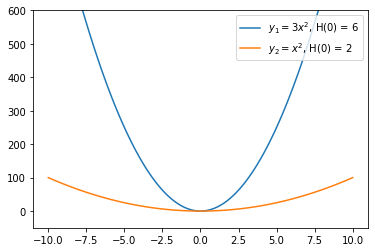

In [438]:
# x = np.linspace(-10,10,100)
# y_1 = 10*x**2
# y_2 = x**2
# fig, ax = plt.subplots()
# ax.plot(x,y_1,label = '$y_1 = 3x^2$, H(0) = 6')
# ax.plot(x,y_2,label = '$y_2 = x^2$, H(0) = 2')
# ax.set_ylim(top = 600)
# ax.legend(loc = 'upper right')
# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/hessian.png')

In [439]:
def hessian_compute_new(fn,loc):
    f_ = fn
    loc_ = loc
    hess = np.empty([loc.shape[0],loc.shape[0]])
    with tf.GradientTape(persistent=True) as t:  
        t.watch(loc_)
        loss = f_(loc_)
        jacobian = t.gradient(loss,loc_)
        for i in range(loc_.shape[0]):
            hess[i] = t.gradient(jacobian[i],loc_)
    return hess

In [440]:
def f(x):
    return x**2
loc = tf.zeros(1)
hessian_compute_new(f,loc)

array([[2.]])

In [441]:
def f(x):
    return 3*x**2
loc = tf.zeros(1)
hessian_compute_new(f,loc)

array([[6.]])

#### Compute the Hessian and Covariance of the Posterior at MAP

Laplace approximation

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [98]:
cov= [[1.,0.],[0.,1.]]
cov = tf.convert_to_tensor(cov,dtype = tf.float32)
tf.linalg.inv(cov)

<tf.Tensor: id=26217086, shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [99]:
# C_post = [[5.3157514e-01, 2.5224808e-04],
#        [2.5224808e-04, 9.8040411e-03]]

In [101]:
Sum = 0
Sum = tf.add(hess,tf.linalg.inv(cov))
C_post = tf.linalg.inv(Sum)
C_post

<tf.Tensor: id=26217094, shape=(2, 2), dtype=float32, numpy=
array([[0.01031344, 0.        ],
       [0.        , 0.000998  ]], dtype=float32)>

Text(0, 0.5, 'x2')

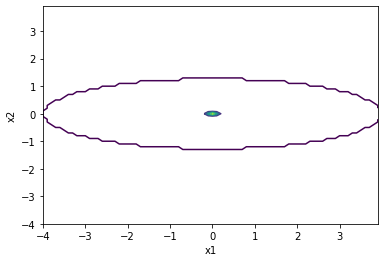

In [102]:
from scipy.stats import multivariate_normal
loc  = [0.,0.]
cov = C_post
x, y = np.mgrid[-4:4:.1, -4:4:.1]
pos = np.empty(x.shape + (2,)) 
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(loc, cov)
plt.contour(x, y, rv.pdf(pos))
plt.xlabel("x1")
plt.ylabel("x2")

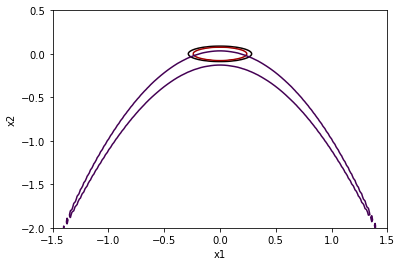

In [103]:

def plot_dist(loc,cov):
    x, y = np.mgrid[-4:4:.01, -4:4:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal(loc, cov)
#     plt.contour(x, y, rv.pdf(pos),np.arange(0.00001,0.0007,0.0001))
    plt.contour(x, y, rv.pdf(pos),[1.,3,10.], cmap=plt.get_cmap('hot'))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_dist(MAP,C_post)

draw_post() 

# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/hess_banana.png')

#### Define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}


gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

$\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}$  is the negative log posterior

In [29]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float32)
    matrix2 = tf.cast(matrix2,tf.float32)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

In [34]:
def negative_log_post(vars):
    return(tf.negative(joint_log_post(D,vars[0],vars[1])))

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.subtract(negative_log_post(m_current),matrixcompute(m_current,MAP,C_post))
    delta_proposed = tf.subtract(negative_log_post(m_proposed),matrixcompute(m_proposed,MAP,C_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        

In [104]:
from IPython.display import clear_output
# define leaning rate
beta = 0.2

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed

In [105]:
mu_init = [-0.,-0.]

In [106]:
number_of_steps = 5000
def run_chain():
    burn_in = 2000
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted = np.array(accepted)



acceptance rate = 65.6%


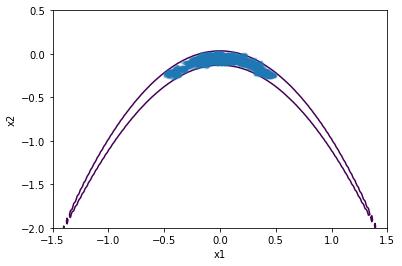

In [107]:
# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(accepted[:,0],accepted[:,1],'.',alpha = 0.3)
draw_post()
# plt.savefig('/Users/zhouji/Documents/IRTG 2019/Presentation/Input/hess_result.png')

In [337]:
number_of_steps = 10000
def run_chain():
    burn_in = 0
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
#         if k%20 == 0: 
#             clear_output();
#             print(k, "finised")
        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()

In [38]:
np.shape(accepted)[0]
print('acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

acceptance rate = 93.0%


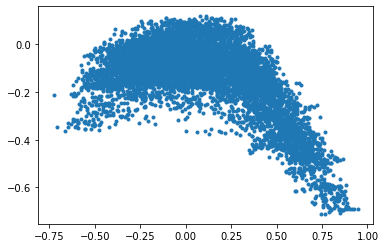

In [340]:
accepted = np.array(accepted)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(accepted[:,0],accepted[:,1],'.')


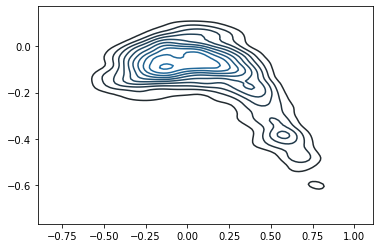

In [339]:
sns.kdeplot(accepted)

### Tascks: 
1.  make a plot of the true density
2.  Create a gempy model, better with gravity


Likelihood

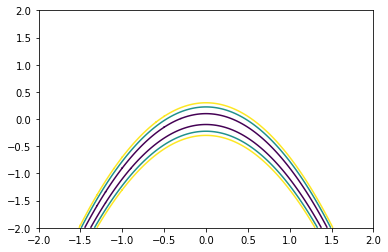

In [30]:
s = 0.01  # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-2, 2+s, s)   #Could use linspace instead if dividing
Y = np.arange(-2, 2.+s, s)   #evenly instead of stepping...

#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

Z =  (Y+X*X)**2

plt.contour(X,Y,Z,[0.01,0.05,0.09])

Prior

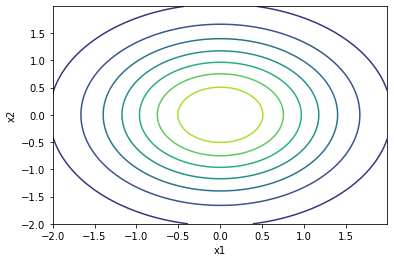

In [31]:
def plot_Prior():
    x, y = np.mgrid[-2:2:.01, -2:2:.01]
    pos = np.empty(x.shape + (2,)) 
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    plt.contour(x, y, rv.pdf(pos))
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_Prior()

Try again put them in a inference problem

In [113]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (tf.exp(mvn.prob(tf.squeeze(z))
           +tf.reduce_sum(y.prob(D))))

In [114]:
# y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
# tf.reduce_prod(y.prob(D))

In [115]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

post = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        post[i][j] = joint_post_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

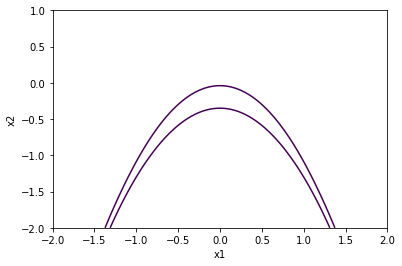

In [116]:
plt.contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")

#### make a function to plot the true density

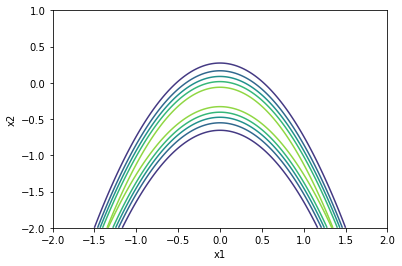

In [117]:
def plot_truepost():
    plt.contour(x, y, post)
    plt.xlim(-2,2)
    plt.ylim(-2,1)
    plt.xlabel("x1")
    plt.ylabel("x2")
plot_truepost()

likelihood

In [102]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def likelihood_prob(y,theta1,theta2):
    # define random variables prior
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)

    return(y.prob(D))

In [104]:
# def multivariate_normal(x, d, mean, covariance):
#     """pdf of the multivariate normal distribution."""
#     x_m = x - mean
#     return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
#             np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [ ]:
def likelihood(mu,sigma,x):
    

In [106]:
likelihood_prob(D,-1.,-1.)

<tf.Tensor: id=50688279, shape=(100,), dtype=float32, numpy=
array([0.11852656, 0.35082045, 0.27916637, 0.3175398 , 0.24357706,
       0.04958992, 0.39865258, 0.3373914 , 0.09527408, 0.30577326,
       0.31244272, 0.38152945, 0.21731788, 0.39882207, 0.28131896,
       0.2559665 , 0.396823  , 0.22954656, 0.38699   , 0.33161986,
       0.28043038, 0.15645514, 0.11792156, 0.25640616, 0.32087597,
       0.38999292, 0.33335066, 0.38605025, 0.35875905, 0.36812472,
       0.24894464, 0.14426139, 0.01804098, 0.09469493, 0.3949512 ,
       0.07429725, 0.37448597, 0.35599464, 0.35783136, 0.39716896,
       0.24605526, 0.26648703, 0.28921586, 0.07252827, 0.33239573,
       0.10574658, 0.04206104, 0.07356273, 0.05766997, 0.39133456,
       0.39744973, 0.14571816, 0.25787392, 0.15151331, 0.27348062,
       0.39223272, 0.37632185, 0.3988246 , 0.17588976, 0.2694407 ,
       0.36813956, 0.3989237 , 0.07935382, 0.2891691 , 0.3915648 ,
       0.17196114, 0.24164866, 0.3337811 , 0.28613952, 0.07877778,
 

In [43]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y
likelihood = np.empty(x.shape)
for i in range(400):
    for j in range(400):
        likelihood[i][j] = likelihood_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

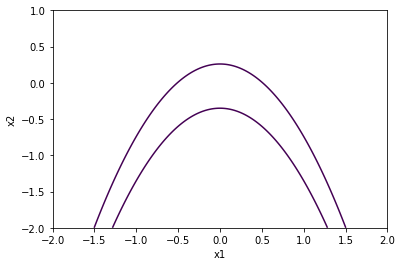

In [44]:
plt.contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,1)
plt.xlabel("x1")
plt.ylabel("x2")
    

Prior

In [45]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def prior_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    return(mvn.prob(tf.squeeze(z)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

prior = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        prior[i][j] = prior_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

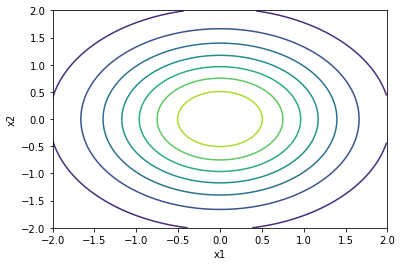

In [46]:
plt.contour(x, y, prior)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Let's add more observations, we shall expect broader extension

In [47]:
c = 0 # mean of observations
N = 1000 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_prob(y,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return(mvn.prob(tf.squeeze(z))
          +tf.reduce_sum(y.prob(D)))

x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.empty(x.shape + (2,),dtype = np.float32) 
pos[:, :, 0] = x; pos[:, :, 1] = y

pdf_1 = np.empty(x.shape)

for i in range(400):
    for j in range(400):
        pdf_1[i][j] = joint_prob(D,pos[i][j][0],pos[i][j][1])

Text(0, 0.5, 'x2')

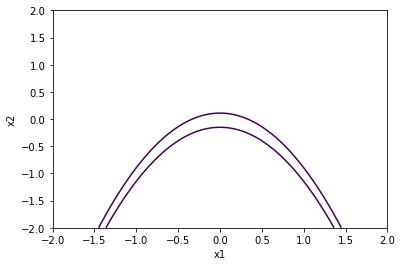

In [48]:
plt.contour(x, y, pdf_1,[joint_prob(D,0.1,0.1).numpy()])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")

Plot the results together

In [86]:
likelihood_prob(D,-0.5,-0.35).numpy()

inf

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """
/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: No contour levels were found within the data range.
  if __name__ == '__main__':


Text(0.5, 1.0, '(c) Posterior')

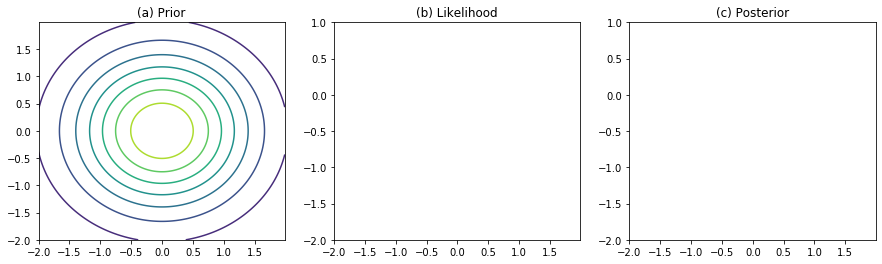

In [88]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

Text(0.5, 1.0, '(c) Posterior')

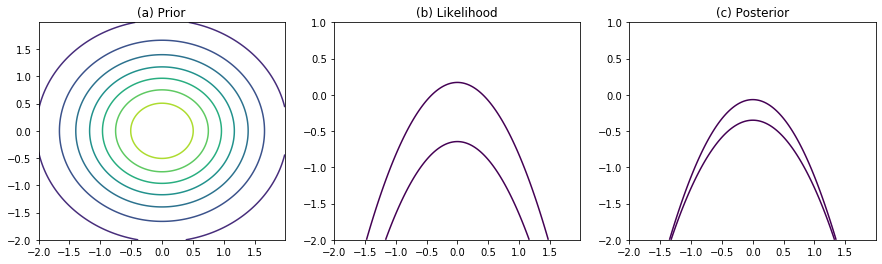

In [318]:
fig, ax = plt.subplots(1, 3,figsize=(15,4))
ax[0].contour(x, y, prior)
ax[0].set_title('(a) Prior')

ax[1].contour(x, y, likelihood,[likelihood_prob(D,0.,-0.35).numpy()])
ax[1].set_ylim(-2,1)
ax[1].set_title('(b) Likelihood')

ax[2].contour(x, y, post,[joint_post_prob(D,0.,-0.35)])
ax[2].set_ylim(-2,1)
ax[2].set_title('(c) Posterior')

(a) Prior, (b) likelihood and (c) posterior for the warped bivariate Gaussian distribution with n=100 values generated from the likelihood with parameter settings $\sigma_y$,$\sigma$ = 11: as the sample size increases and the prior becomes more diffuse, the posterior becomes less identifiable and the ridge in the posterior becomes stronger 

In [87]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [143]:
c = 0 # mean of observations
N = 100 # number of observation data
sigma2y = 1 # standard deviation of observation data
## generate the observation data
y_ = np.random.normal(loc =c, scale = sigma2y, size = N)
D = tf.convert_to_tensor(y_,dtype = tf.float32)

def joint_post_prob(D,theta1,theta2):
    # define random variables prior
    mvn = tfd.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    z = tf.stack([theta1, theta2], axis=-1)
    # define likelihood
    y = tfd.Normal(loc = tf.add(theta2,tf.pow(theta1,2.)), scale = sigma2y)
    # return the posterior probability
    return (mvn.log_prob(tf.squeeze(z))
           +tf.reduce_sum(y.log_prob(D)))

In [8]:
num_results = 5000
burnin = 1000

initial_chain_state = [
    -0. * tf.ones([], dtype=tf.float32, name="init_t1"),
    -0. * tf.ones([], dtype=tf.float32, name="init_t2")
]

unnormalized_posterior_log_prob = lambda *args: joint_log_prob(y_, *args)

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size = 0.01,
        num_leapfrog_steps = 5),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

x1 = samples[:,0]
y1 = samples[:,1]

x_accepted = []
y_accepted =[]

/Users/zhouji/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 98.7%


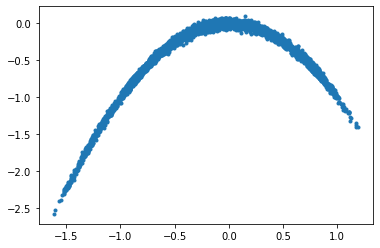

In [9]:
for i in range(accepted.shape[0]):
    if accepted[i-1]==True:
        x_accepted = np.append(x_accepted,samples[i-1,0])
        y_accepted = np.append(y_accepted,samples[i-1,1])
# f,(ax1,ax2) = plt.subplots(2,1,sharex =True, sharey = True)

# sns.kdeplot(x_accepted,y_accepted,ax=ax1)
plt.plot(x_accepted,y_accepted,'.')
# plot_true()

print('Acceptance rate: %0.1f%%' % (100*(x_accepted.shape[0]/num_results)))


NameError: name 'plot_dist' is not defined

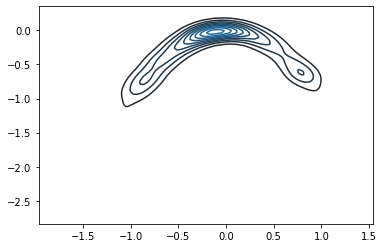

In [22]:
sns.kdeplot(samples)
plot_dist(MAP,C_post)